In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 1000
innov_dim = 250

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(logit_rho=true_params['logit_rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(logit_rho=true_params['logit_rho'], log_scale=true_params['log_scale'], 
                          phi=true_params['phi'], theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
vl.compute_moments(**true_params)

{'return_mean': 0.020348646250984467,
 'return_var': 0.017873157660876236,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [8]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [9]:
data.vol.describe()

count    2000.000000
mean        0.012484
std         0.016252
min         0.000010
25%         0.001859
50%         0.006204
75%         0.016347
max         0.120227
Name: vol, dtype: float64

In [10]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'gamma': 0.012227592917921712,
 'beta': 4.076658793315888,
 'psi': -3.440207320203121,
 'zeta': 0.84}

In [11]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [12]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'gamma': 0.012227592917921712,
 'beta': 4.076658793315888,
 'psi': -3.440207320203121,
 'zeta': 0.84}

In [13]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [14]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

## We start by examining the distributions of simulated data

In [15]:
data.corr()

,vol,rtn
vol,1.000000,-0.058042
rtn,-0.058042,1.000000


In [16]:
data.head()

,vol,rtn
2000-01-01,0.016073,0.035764
2000-01-02,0.021390,0.205232
2000-01-03,0.008994,0.023206
2000-01-04,0.005133,0.051460
2000-01-05,0.005675,0.070586


In [17]:
data.vol.var()

0.0002641198139716198

In [18]:
vl.compute_vol_gmm(data.vol)

({'log_both': -6.096862761009443,
  'log_scale': -5.48373070527655,
  'logit_rho': 1.525460950359776},
            log_both  log_scale  logit_rho
 log_both   0.008645   0.001376  -0.008265
 log_scale  0.001376   0.002036  -0.000349
 logit_rho -0.008265  -0.000349   0.020996)

In [19]:
omega, omega_cov = vl.estimate_params(data)

In [20]:
omega

{'gamma': 0.013070192868700616,
 'beta': 3.7121558147357065,
 'psi': -3.6177715166113336,
 'zeta': 0.8392534214047641,
 'log_both': -6.096862761009443,
 'log_scale': -5.48373070527655,
 'logit_rho': 1.525460950359776}

In [21]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.019173,-4.032383e-05,0.000000,0.000000,0.000000,-0.015948,0.000000
gamma,-0.000040,2.819461e-07,0.000000,0.000000,0.000000,0.000018,0.000000
log_both,0.000000,0.000000e+00,0.008645,0.001376,-0.008265,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.001376,0.002036,-0.000349,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.008265,-0.000349,0.020996,0.000000,0.000000
psi,-0.015948,1.774778e-05,0.000000,0.000000,0.000000,0.048216,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000683


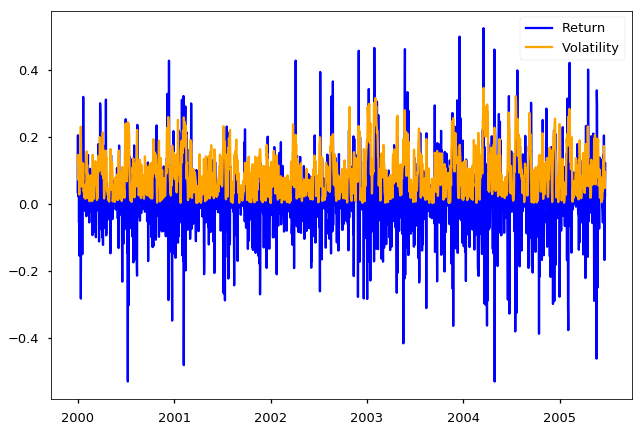

In [22]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [23]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.004031,-0.000419
rtn,-0.000419,0.011447


In [24]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'gamma': 0.012227592917921712,
 'beta': 4.076658793315888,
 'psi': -3.440207320203121,
 'zeta': 0.84}

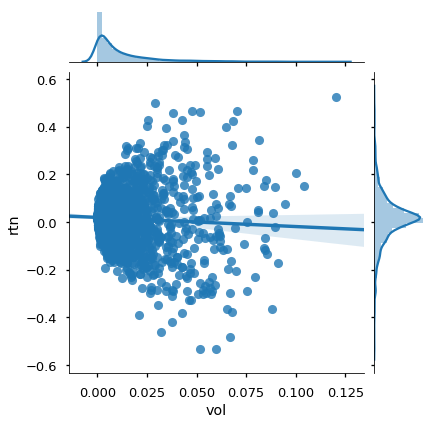

In [25]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [26]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.012484,0.014273
std,0.016252,0.106993
min,0.000010,-0.531630
25%,0.001859,-0.028298
50%,0.006204,0.015610
75%,0.016347,0.058719
max,0.120227,0.525652


## I now estimate all of the parameters

In [27]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [28]:
vl.compute_init_constants(data.vol)

{'log_both': -6.02949299225631,
 'log_scale': -5.500986509194163,
 'logit_rho': 1.430340194667869}

In [29]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [30]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [31]:
vl.compute_init_constants(data.vol)

{'log_both': -6.02949299225631,
 'log_scale': -5.500986509194163,
 'logit_rho': 1.430340194667869}

In [32]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.914383360414941,
  'log_scale': -5.484940703993587,
  'logit_rho': 1.4269396730703177},
            log_both  log_scale  logit_rho
 log_both   0.010240   0.001603  -0.011913
 log_scale  0.001603   0.002446  -0.000917
 logit_rho -0.011913  -0.000917   0.024959)

In [33]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.compute_vol_gmm, [data.vol for data in data_arr]),
                                      total=len(data_arr)))

In [34]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [35]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

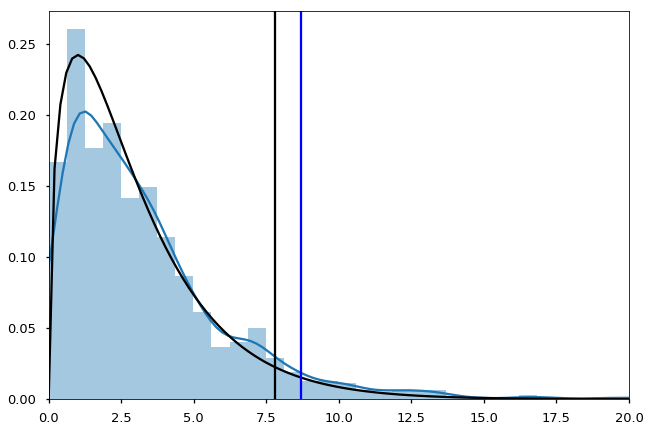

In [36]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
vol_ax.set_xlim([0,20])
vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [37]:
100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

7.000000000000001

In [38]:
t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
            for est in est_arr for name in ['logit_rho', 'log_scale', 'log_both']]
t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [39]:
true_params['log_both']

-5.97088622074413

In [40]:
np.amin([est[0]['log_both'] for est in est_arr])

-6.556660517618907

In [41]:
t_stats_df.describe()

,log_both,log_scale,logit_rho
count,1000.000000,1000.000000,1000.000000
mean,0.147977,-0.030749,-0.185979
std,1.020958,1.021762,1.046566
min,-2.821399,-3.597277,-3.948555
25%,-0.533121,-0.695377,-0.825913
50%,0.104347,-0.028452,-0.166005
75%,0.797538,0.627164,0.532127
max,3.435767,3.386284,2.667960


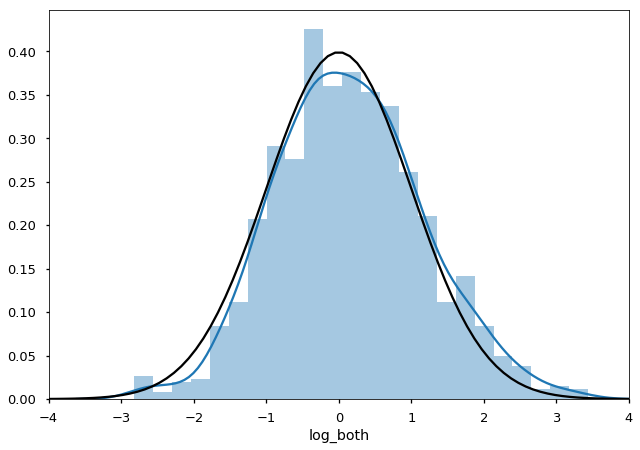

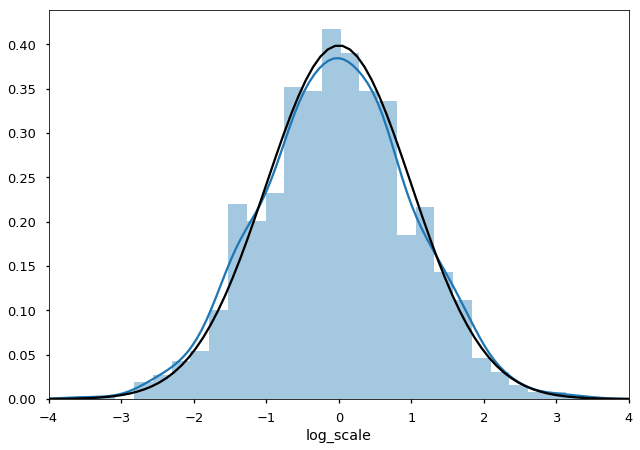

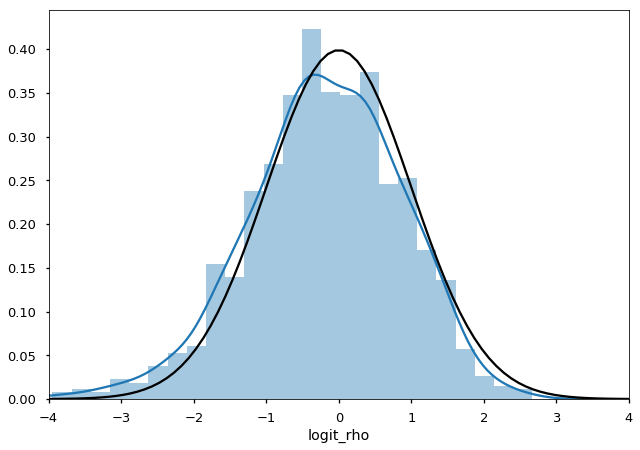

In [42]:
for name, col in t_stats_df.items():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    ax.set_xlim([-4,4])

In [ ]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   log_rho=true_params['log_rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

In [ ]:
fig, ax = mpl.pyplot.subplots()       
sns.distplot(pd.Series([est['pi'] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
ax.axvline(total_true_params['pi'], color='black')
ax.set_xlabel('$\pi$')
fig.savefig('../doc/figures/pi_est_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
                        frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


In [ ]:
true_params

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

In [ ]:
compute_ar(est_arr[0])

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
 stats.chi2.ppf(df=4, q=.95)

In [ ]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)